# Implementación de selección de clientes Active Federated Learning (AFL)

Usaremos el framework FLEXible para establecer un escenario de Aprendizaje Federado (FL) sobre un modelo de __Regresión Lineal__ para ajustar el dataset de _diabetes_. Para poder comparar y tener una plantilla de inicio nos basaremos en el ejemplo tomado del proyecto de FLEX: [Federating a linear regressor example](https://github.com/FLEXible-FL/FLEXible/blob/main/notebooks/Federating%20a%20linear%20regression%20model.ipynb), y lo adaptaremos para hacer uso del método de selección AFL.

Primero, seleccionamos el dataset de _diabetes_ por la misma razón que el ejemplo de FLEX, por simplicidad. Después, separamos los datos en datos de train y test de forma aleatoria con una proporción del $33\%$ para test usando las herramientas de `sklearn`.

In [72]:
# importamos los paquetes
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import numpy as np

In [73]:
# cargar dataset
diabetes = load_diabetes()

X_train, X_test, y_train, y_test = train_test_split(
	diabetes.data[:, np.newaxis, 2], diabetes.target, test_size=0.33, random_state=42
)

print("# train examples:", y_train.size)
print("# test examples:", y_test.size)

# train examples: 296
# test examples: 146


Luego, federamos nuestro datos realizando una distribución IID respecto al número de nodos que dispongamos (clientes).

In [74]:
from flex.data import FedDataDistribution, Dataset

In [75]:
# use Dataset to represent our data for one node
train_diabetes = Dataset.from_array(X_train, y_train)
test_diabetes = Dataset.from_array(X_test, y_test)

# IID-distribute the data to a number of 5 nodes
federated_diabetes = FedDataDistribution.iid_distribution(train_diabetes, n_nodes=5)

# assign test data to the server
server_id = "server"
federated_diabetes[server_id] = test_diabetes

En el ejemplo de FLEX, ellos comparan tanto el modelo centralizado como el federado entrenando primero de una forma centralizada y luego se explica el proceso de hacerlo federado. Para seguir con el ejemplo, y eventualmente comparar los resultados de tanto de AFL como la manera convencional de selección de clientes, nosotros entrenamos el centralizado a continuación.

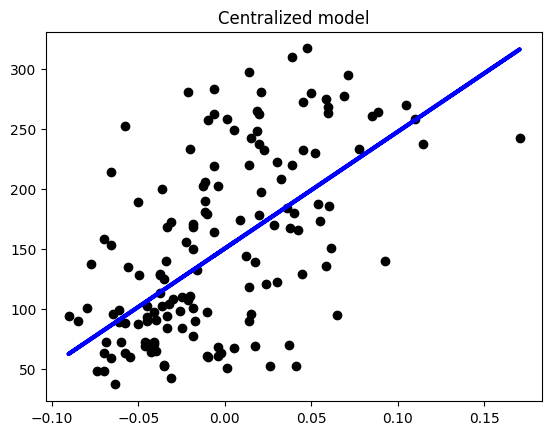

In [76]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


def plot_lm(lm, test_data, title):
    preds = lm.predict(test_data.X_data)
    # Plot outputs
    plt.title(title)
    plt.scatter(test_data.X_data, test_data.y_data, color="black")
    plt.plot(test_data.X_data, preds, color="blue", linewidth=3)


centralized_model = LinearRegression()

# train model
centralized_model = centralized_model.fit(train_diabetes.X_data, train_diabetes.y_data)

# get predictions
plot_lm(centralized_model, test_diabetes, "Centralized model")

En FLEX utilizan la raíz del error cuadrático medio (RMSE) y el R2-Score como métricas; usaremos esta mismas en el transcurso de este notebook por razones de comparación entre las distintas técnicas que estudiaremos.

In [77]:
from sklearn import metrics
from math import sqrt


def score_model(labels, preds):
    rmse = sqrt(metrics.mean_squared_error(labels, preds))
    r2_score = metrics.r2_score(labels, preds)

    results = rmse, r2_score

    print("-----------------")
    print("RMSE: {},\nr2: {}".format(*results))
    print("-----------------")


print("Centralized model scores")
preds = centralized_model.predict(test_diabetes.X_data)
score_model(test_diabetes.y_data, preds)

Centralized model scores
-----------------
RMSE: 62.7221434289942,
r2: 0.3164396837685731
-----------------


## Federar el modelo

Ahora vamos a usar FLEX para poder federar el modelo centralizado para poder entrenar el modelo utilizando Aprendizaje Federado sobre $5$ clientes (como hemos establecido en la distribución de los datos del dataset). En FLEX hay muchas maneras de federar un modelo de ML, nosotros tomaremos directamente el ejemplo del proyecto de FLEX (más información en la federación de este regresor lineal en el notebook [Federating a linear regressor example](https://github.com/FLEXible-FL/FLEXible/blob/main/notebooks/Federating%20a%20linear%20regression%20model.ipynb).

Primero construimos una _pool_, que es esencialmente una estructura de datos que contiene todas las entidades en un escenario de FL. A esta pool debemos de pasarle como parámetros nuestro dataset federado que hemos construido anteriormente, un identificador para el servidor (en nuestro caso `"server"`) y una función de inicialización del modelo, para este usamos el decorador `init_server_model` que nos facilita el asignar la función a nuestro pool de FLEX; en esta función simplemente inicializamos un modelo de FLEX donde el modelo de aprendizaje sera un `LinearRegression` de `sklearn`.

In [78]:
from flex.pool import init_server_model
from flex.pool import FlexPool
from flex.model import FlexModel


@init_server_model
def build_server_model():
    flex_model = FlexModel()
    flex_model["model"] = LinearRegression()
    return flex_model


p = FlexPool.client_server_pool(
    federated_diabetes, server_id=server_id, init_func=build_server_model
)

clients = p.clients
servers = p.servers
aggregators = p.aggregators

print(
    f"Number of nodes in the pool {len(p)}: {len(servers)} servers plus {len(clients)} clients. The server is also an aggregator"
)

Number of nodes in the pool 6: 1 servers plus 5 clients. The server is also an aggregator


Luego, definimos el cómo se van a distribuir el modelo alojado en el servidor a los clientes. En este caso convencional de FL, simplemente tomamos el modelo y devolvemos una _deepcopy_ o copia profunda de este. Para facilitar la tarea de implementar esta función desde cero, utilizamos el decorador `deploy_server_model` que comprueba que la función cumpla con ciertas condiciones y realiza las iteraciones de distribución a los clientes.

In [79]:
import copy

from flex.pool import deploy_server_model


@deploy_server_model
def copy_server_model_to_clients(server_flex_model: FlexModel):
    return copy.deepcopy(server_flex_model)


servers.map(copy_server_model_to_clients, clients)

La función `map` la usamos para comunicar _desde_ el servidor como distribuir los modelos _a_ los clientes, de manera que el modelo a copiar venga del servidor y no de otra entidad.

Ahora procedemos a definir la forma en la que los clientes entrenan el modelo con sus datos locales. Esto lo realizamos definiendo una función `train` al que se le pasa un modelo local (la del cliente en cuestión) y el dataset; y mediante un `map` comunicamos la función a los clientes.

Para el entrenamiento en sí, simplemente accedemos al modelo del cliente, que recordemos que es un modelo de `sklearn`, y usamos la función para ajustar el modelo `fit`.

In [80]:
def train(client_flex_model: FlexModel, client_data: Dataset):
    client_flex_model["model"].fit(client_data.X_data, client_data.y_data)


clients.map(train)

Ahora, debemos de definir como el servidor recolecta los nuevos modelos locales de los clientes. Esto aunque pueda parecer la fase de _agregación_, no es sino la fase propia de recolectar los gradientes o pesos de los clientes para luego en una fase posterior agregarlos. Usaremos el decorador `collect_client_weights` que nos facilita la tarea de definir la función que recolecta estos pesos. En esencia diremos que devuelve cada cliente una lista con dos elementos `intercept` y `coef` (un hiperplano de dos dimensiones) que definen el nuevo modelo a enviar al servidor, es decir, un `map` aplicado a cada cliente desde el servidor.

In [81]:
from flex.pool import collect_clients_weights


@collect_clients_weights
def get_clients_weights(client_flex_model: FlexModel):
    return [client_flex_model["model"].intercept_, client_flex_model["model"].coef_]


aggregators.map(get_clients_weights, clients)
# The same as:
# servers.map(get_client_weights, clients)

Nótese que la entidad que realiza esta acción (así como posteriormente la de agregación) la realizan los que tienen rol de _agregadores_; en un escenario convencional de FL, el servidor es tanto de rol _servidor_ y _agregador_.

Ahora debemos de indicar _cómo_ se agregaran estos pesos una vez los tengamos en el servidor. Como hemos visto en la celda anterior, los pesos se devuelven individualmente en una lista de dos elementos, por lo que el servidor tendrá a disposición una lista de listas de dos elementos. Como estamos implementando la manera _naive_ de FL usaremos el agregador FedAvg que toma la media de estos pesos.

In [82]:
from flex.pool import aggregate_weights
import numpy as np


@aggregate_weights
def aggregate(list_of_weights: list):
    return np.mean(np.asarray(list_of_weights, dtype=object), axis=0)


# Aggregate weights
aggregators.map(aggregate)
# The same as:
# servers.map(aggregate)

Para completar finalmente una ronda de FL, es necesario ahora definir el como vamos a _establecer_ este nuevo modelo agregado. En este caso es sencillamente acceder al modelo del servidor y asignarle el nuevo calculado en la fase de agregación.

In [83]:
from flex.pool import set_aggregated_weights


@set_aggregated_weights
def set_agreggated_weights_to_server(server_flex_model: FlexModel, aggregated_weights):
    server_flex_model["model"].intercept_ = aggregated_weights[0]
    server_flex_model["model"].coef_ = aggregated_weights[1]


# Set aggregated weights in the server model
aggregators.map(set_agreggated_weights_to_server, servers)
# The same as:
# servers.map(set_agreggated_weights_to_server, servers)

La siguiente función nos servirá para visualizar los resultados al finalizar las rondas de entrenamiento federado.

-----------------
RMSE: 62.72763325807868,
r2: 0.31632001969695445
-----------------


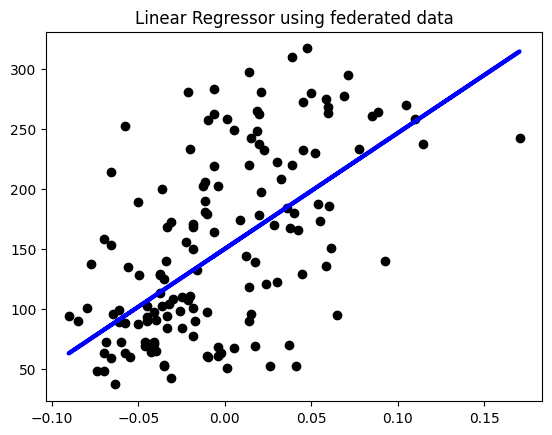

In [84]:
def evaluate_global_model(server_flex_model: FlexModel, test_data: Dataset):
    preds = server_flex_model["model"].predict(test_data.X_data)
    plot_lm(server_flex_model["model"], test_data, title="Linear Regressor using federated data")
    score_model(test_data.y_data, preds)


servers.map(evaluate_global_model)

## Ajuste del modelo federado para unas pocas rondas

Ahora teniendo nuestro modelo federado así como los datos de nuestro dataset, es hora de iniciar el entrenamiento. Esto se realiza iterando una y otra vez sobre cada ronda aplicando las fases que hemos estado definiendo anteriormente. En concreto, cada vez que hacíamos `map` con una función de una fase estabamos efectivamente realizando aquella función sobre nuestro modelo; por tanto, un entrenamiento federado sobre $T$ rondas es sencillamente hacer `map` de forma iterativa sobre $T$ rondas.

Por mostrar el mismo ejemplo que en el repositorio de FLEX, usaremos $T=1$ rondas.

Federated model scores
-----------------
RMSE: 62.72763325807868,
r2: 0.31632001969695445
-----------------


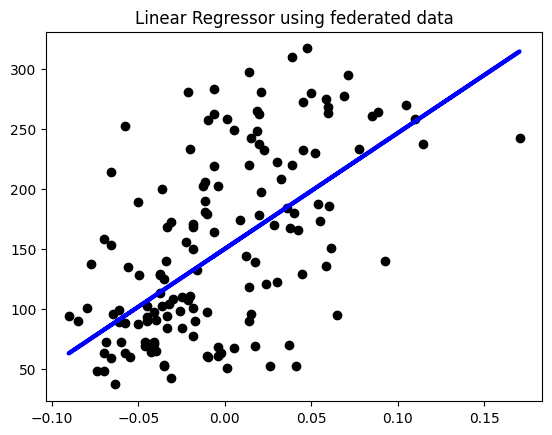

In [85]:
n_rounds = 1
p = FlexPool.client_server_pool(
    federated_diabetes, server_id=server_id, init_func=build_server_model
)
servers = p.servers
clients = p.clients
aggregators = p.aggregators

for i in range(n_rounds):
    servers.map(copy_server_model_to_clients, clients)
    clients.map(train)
    aggregators.map(get_clients_weights, clients)
    aggregators.map(aggregate)
    aggregators.map(set_agreggated_weights_to_server, servers)

print("Federated model scores")
servers.map(evaluate_global_model)

Centralized model scores
-----------------
RMSE: 62.7221434289942,
r2: 0.3164396837685731
-----------------


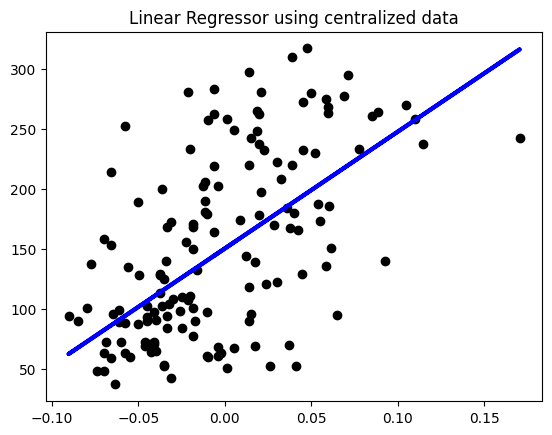

In [86]:
print("Centralized model scores")
preds = centralized_model.predict(test_diabetes.X_data)
score_model(test_diabetes.y_data, preds)
plot_lm(centralized_model, test_diabetes, title="Linear Regressor using centralized data")

Para este ejemplo vemos que conseguimos un rendimiento del modelo global federado muy cercano al centralizado, mostrando que el ajuste con FL resultó exitoso.

## Modificando el modelo para seleccionar clientes con AFL

In [89]:
# initialize FL setup
n_rounds = 1
p = FlexPool.client_server_pool(
    federated_diabetes, server_id=server_id, init_func=build_server_model
)
servers = p.servers
clients = p.clients
aggregators = p.aggregators

In [123]:
from typing import List

def copy_model(flex_model):
    return copy.deepcopy(flex_model)

def copy_server_model_to_selected_clients(
    server_flex_model: FlexModel,
    clients_flex_models: List[FlexModel]
):
    selected = server_flex_model["selected_clients"] if "selected_clients" in server_flex_model.keys() else clients_flex_models

    for k in range(len(clients_flex_models)):
        if k in selected:
            clients_flex_models[k].update(copy_model(server_flex_model))

            # mark client as selected
            clients_flex_models[k]["selected"] = True
        else:
            # set 'not selected' to the remainder clients
            clients_flex_models[k]["selected"] = False

servers.map(copy_server_model_to_selected_clients, clients)

Para poder implementar el método AFL en la selección de clientes en nuestro escenario de FL necesitamos saber en que fase de una ronda del aprendizaje debemos de modificar para poder implementar el algoritmo de sampleado definido en [1].

En este caso, podemos ver que el algoritmo se trata de un algoritmo de sampleado o muestreo que se realiza al final de cada iteración de entrenamiento para seleccionar los siguientes clientes. Nótese que aquí _iteración de entrenamiento_ se refiere a cada ronda, es decir, al final de cada ronda se elige el siguiente conjunto de clientes seleccionados $S$ de la siguiente ronda.


> [1] https://arxiv.org/abs/1909.12641.

Primero definimos la función de valuación $\mathcal V: \mathcal X^{n_k} \times \mathcal Y^{n_k} \times \R^d \longrightarrow \R$, que depende del modelo actual del cliente $\text{w}$ y de sus datos $\text{x}, \text{y}$. Utilizaremos la misma definición de la función $\mathcal V$ que utilizaron los autores en [1]:
$$\mathcal v_k = \frac{1}{\sqrt{n_k}}l(\text{x}_k,\text{y}_k;\text{w}^{(t)})$$

In [124]:
from typing import Callable

def client_train_loss(client_model: FlexModel, client_data: Dataset, loss_func: Callable):
	# get predictions
	y_pred = client_model["model"].predict(client_data.X_data)
	y_true = client_data.y_data

	# return the loss on client data
	return loss_func(y_true, y_pred)

def client_val_lin(client_model: FlexModel, client_data: Dataset) -> float:
	return client_train_loss(client_model, client_data, metrics.mean_squared_error) / len(client_data)

Vamos a usar la función de valuación en la fase de entrenamiento, de manera que al finalizar el entrenamiento recuperemos su valor de perdida. Podemos entonces guardar la valuación en el diccionario del modelo FLEX del cliente.

> Nótese que con un modelo de `sklearn` no podremos recuperar al momento de finalizar el entrenamiento su valor de perdida, esto debido a que los modelos de `sklearn` no implementan un historial del valor de perdida en training; sin embargo, esta forma si funcionaría en otros frameworks como PyTorch o Tensorflow que si guardan el valor de perdida después de training.

In [125]:
def train(client_flex_model: FlexModel, client_data: Dataset):
	if client_flex_model["selected"]:
		# train model on client data
		client_flex_model["model"].fit(client_data.X_data, client_data.y_data)

		# compute the client valuation after training
		val = client_val_lin(client_flex_model, client_data)
		
		# store this valuation on client FLEX model
		client_flex_model["val"] = val

clients.map(train)

Ahora debemos de definir como el servidor va a recuperar estos datos. En el caso convencional hemos visto que simplemente devuelve una lista de dos elementos (sus pesos); en este caso simplemente podemos agregar un tercer elemento que sea la valuación.

In [126]:
@collect_clients_weights
def get_clients_weights(client_flex_model: FlexModel):
    # return weights if client was selected, null weights otherwise
    return [client_flex_model["model"].intercept_, client_flex_model["model"].coef_]

def get_client_vals(
    aggregator_flex_model: FlexModel,
    clients_flex_models: List[FlexModel],
):
	# number of valuations must be exact to the number of clients, we reinitialize the list for that
    aggregator_flex_model["vals"] = []
    for k in clients_flex_models:
        client_val = clients_flex_models[k]["val"]
        aggregator_flex_model["vals"].append(client_val)

aggregators.map(get_clients_weights, clients)
aggregators.map(get_client_vals, clients)

En la fase de agregación seguirá siendo la misma (aplicar FedAvg) pero esta vez teniendo en cuenta que hemos agregado un tercer elemento que es la función de valuación.

In [127]:
from flex.pool import aggregate_weights
import numpy as np


@aggregate_weights
def aggregate(list_of_weights: list):
    return np.mean(np.asarray(list_of_weights, dtype=object), axis=0)


# Aggregate weights
aggregators.map(aggregate)

In [128]:
import math

alpha1 = 0.75
alpha2 = 0.01
alpha3 = 0.1
K = 5
m = 3

def client_selection(agg_model: FlexModel, _agg_data: Dataset):
	# get valuations by clients
	clients: dict = dict(enumerate(agg_model["vals"]))

	# sort clients by valuation
	sorted_clients = {k: v for k, v in sorted(clients.items(), key=lambda item: item[1])}

	# for the alpha1 * K users with smalles vk, vk = -infinity
	smallest_val = list(sorted_clients.keys())[:math.floor(alpha1 * K)]
	for key in smallest_val:
		sorted_clients[key] = float('-inf')

	# build probability distribution depending on the valuations
	vals = list(sorted_clients.values())
	
	# get the indexed probability scores
	exp_scores = np.exp(alpha2 * np.array(vals))
	idx = np.array(list(sorted_clients.keys()))
	p = exp_scores / np.sum(exp_scores)

	# sample clients by pk
	Sp_mask = np.argsort(p)[-math.floor(m * (1 - alpha3)):]
	Sp = idx[Sp_mask]

	# sample clients uniformly at random
	remaining = [i for i in idx if i not in Sp]
	Spp = np.random.choice(remaining, size=math.floor(m * alpha3), replace=False)

	# get the union of both S
	agg_model["selected_clients"] = np.union1d(Sp, Spp).tolist()

aggregators.map(client_selection)

In [129]:
@set_aggregated_weights
def set_agreggated_weights_to_server(server_flex_model: FlexModel, aggregated_weights):
    server_flex_model["model"].intercept_ = aggregated_weights[0]
    server_flex_model["model"].coef_ = aggregated_weights[1]


# Set aggregated weights in the server model
aggregators.map(set_agreggated_weights_to_server, servers)

[72.47702300675054, 63.545835035532605, 53.74897716692349, 66.75015223416491, 65.5195640764436]
-----------------
RMSE: 62.72763325807868,
r2: 0.31632001969695445
-----------------


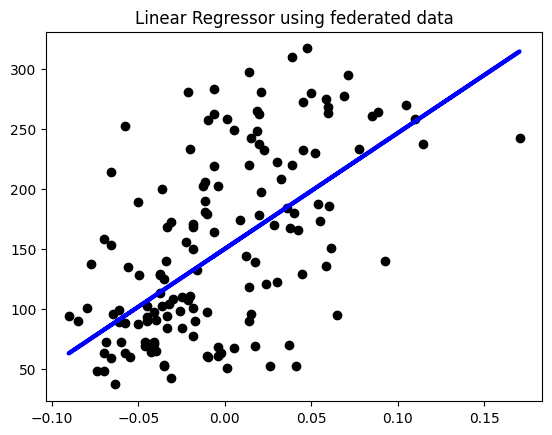

In [130]:
def evaluate_global_model(server_flex_model: FlexModel, test_data: Dataset):
    print(server_flex_model["vals"])
    preds = server_flex_model["model"].predict(test_data.X_data)
    plot_lm(server_flex_model["model"], test_data, title="Linear Regressor using federated data")
    score_model(test_data.y_data, preds)


servers.map(evaluate_global_model)